In [1]:
# Whenever using external files along with Ipython use autoreload. 
# It will reload the external files every time before executing any code in IPython.
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from micrograd.engine import Value
from micrograd.nn import MLP

In [4]:
np.random.seed(1337)
random.seed(1337)

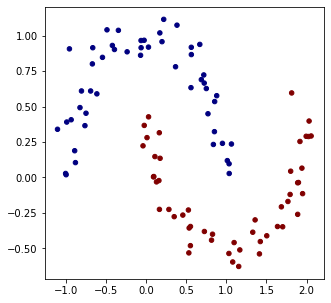

In [17]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [35]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

number of parameters 337


In [37]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    losses = [(ygt-yout)**2 for ygt, yout in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    # # svm "max-margin" loss
    # losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    # data_loss = sum(losses) * (1.0 / len(losses))
    # # L2 regularization
    # alpha = 1e-4
    # reg_loss = alpha * sum((p*p for p in model.parameters()))
    # total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return data_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.0689739079486904, grad=0) 0.69


In [39]:
# optimization
for k in range(20):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    # model.zero_grad()
    for p in model.parameters():
        p.grad = 0.0
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 1.0689739079486904, accuracy 69.0%
step 1 loss 1.8917423216344895, accuracy 50.0%
step 2 loss 0.8750396477509435, accuracy 77.0%
step 3 loss 0.6798714691459471, accuracy 81.0%
step 4 loss 0.5279478117221685, accuracy 85.0%
step 5 loss 0.49973172023871293, accuracy 87.0%
step 6 loss 0.46976145809163006, accuracy 88.0%
step 7 loss 0.34494182792759154, accuracy 91.0%
step 8 loss 0.33383991358779336, accuracy 90.0%
step 9 loss 0.3218305527544632, accuracy 90.0%
step 10 loss 0.17970896952530258, accuracy 95.0%
step 11 loss 0.35804997094380325, accuracy 91.0%
step 12 loss 0.2652805163651501, accuracy 93.0%
step 13 loss 0.08337082495299397, accuracy 96.0%
step 14 loss 0.12669375654702425, accuracy 98.0%
step 15 loss 0.34051233620827404, accuracy 90.0%
step 16 loss 0.09463731248460214, accuracy 96.0%
step 17 loss 0.06661263509135634, accuracy 99.0%
step 18 loss 0.05312857149740181, accuracy 98.0%
step 19 loss 0.06150783179903596, accuracy 99.0%


(-1.6280704325050093, 1.8719295674949907)

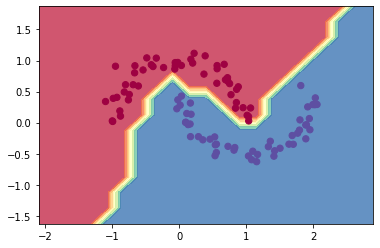

In [40]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
